In [2]:
import json
from pathlib import Path

# Path to your original slice file
folder_path = Path(r"/Users/noa/Desktop/02805 - Social Graphs/playlist_data/")

# Load all mpd slice JSON files in the folder and merge their playlists
file_list = sorted(folder_path.glob("mpd.slice.*.json"))
playlists = []
for fp in file_list:
    with open(fp, 'r', encoding='utf-8') as f:
        data = json.load(f)
        playlists.extend(data.get("playlists", []))

mpd_slice = {
    "info": {"merged_from_files": len(file_list)},
    "playlists": playlists
}

print(f"Loaded {len(file_list)} files, total playlists merged: {len(mpd_slice['playlists'])}")

# Check how many playlists are inside
print(f"Total playlists in this slice: {len(mpd_slice['playlists'])}")


Loaded 6 files, total playlists merged: 6000
Total playlists in this slice: 6000


Make a network going through 6000 playlists (mpd_slice)

Nodes are artists occuring in the songs of the networks

Add song titles from playlists to the nodes, disregarding duplicates.

add playlist id as attribute to artist if they have a song on playlist

Edges are between artists if they share a playlist

weight on edge is the number of playlist they share

dont include playlist having less then 40 songs and more then 100

dont include playlists having less than 6 unique artists. 

In [26]:
import networkx as nx
from collections import defaultdict
from itertools import combinations

# Build network from the mpd_slice playlists (up to first 100 playlists in the slice)
playlists = mpd_slice.get("playlists", [])[:1000]
print(f"\nBuilding artist network from {len(playlists)} playlists")

# Accumulators (dictionaries of sets)
artist_songs = defaultdict(set)        # artist -> set of song titles
artist_playlists = defaultdict(set)    # artist -> set of playlist ids they appear in
edge_playlists = defaultdict(set)      # (artist_a, artist_b) -> set of playlist ids they share

included_playlists = 0

for pl in playlists:
    pid = pl.get("pid")
    tracks = pl.get("tracks", [])
    # filter playlists by track count and unique artist count
    if not (40 <= len(tracks) <= 100):
        continue
    unique_artists = {t["artist_name"] for t in tracks}
    # if len(unique_artists) < 6:
    #     continue

    included_playlists += 1

    # collect songs and playlist membership per artist
    for t in tracks:
        artist = t["artist_name"]
        track_name = t.get("track_name")
        if track_name:
            artist_songs[artist].add(track_name)
        artist_playlists[artist].add(pid)

    # increment edge counters for every pair of artists in this playlist
    for a, b in combinations(sorted(unique_artists), 2):
        edge_playlists[(a, b)].add(pid)



Building artist network from 1000 playlists


Steps to Implement:

- Filter playlists: If any song in a playlist cannot be found on Genius, discard the entire playlist.
- Fetch lyrics: Use the Genius API to get lyrics for each unique song per artist.
- Concatenate lyrics per artist: Combine lyrics for all unique songs by that artist into one text block.
- Save to .txt files: Store each artist’s lyrics in a separate file so you can load them later without re-scraping.
- Attach lyrics as an attribute in the graph: When building the NetworkX graph, add the lyrics as a node attribute.

Considerations
- Avoid duplicates: Only fetch lyrics for unique songs per artist.
- Rate limits: Genius API has limits, so you may need to add delays or caching.
- Error handling: If any song in a playlist fails, skip that playlist entirely.
- File structure: Use a folder like artist_lyrics/ to store .txt files named after the artist.

In [9]:
import lyricsgenius
import os
import re
from pathlib import Path

# --- SETUP GENIUS API ---
GENIUS_ACCESS_TOKEN = "IKoqZN1ANyU_2G6zmTPF2xlaH2OlIEEUlDoD97Mo9-P_A6-2QgnSoQlwsJ3Hy3DY"  # <--- paste your token

# Initialize Genius client
genius = lyricsgenius.Genius(
    GENIUS_ACCESS_TOKEN,
    remove_section_headers=True,   # cleans up [Verse], etc.
    timeout=15,
    retries=3
)

In [14]:
import os
import re
import time
from pathlib import Path
from collections import defaultdict
import lyricsgenius

# Folder to save lyrics
lyrics_folder = Path("artist_lyrics")
lyrics_folder.mkdir(exist_ok=True)

artist_lyrics = defaultdict(str)

for artist, songs in artist_songs.items():
    for track_name in songs:
        try:
            song = genius.search_song(track_name, artist)
            if song and song.lyrics:
                artist_lyrics[artist] += "\n" + song.lyrics
        except Exception as e:
            print(f"Error fetching {track_name} by {artist}: {e}")
        time.sleep(1)  # Avoid hitting rate limits

# Save lyrics to files
for artist, lyrics in artist_lyrics.items():
    safe_name = re.sub(r'[^\w\s-]', '', artist).strip().replace(' ', '_')
    file_path = lyrics_folder / f"{safe_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(lyrics)

print(f"Saved lyrics for {len(artist_lyrics)} artists.")

Searching for "Lose Control (feat. Ciara & Fat Man Scoop)" by Missy Elliott...
Done.
Searching for "Toxic" by Britney Spears...
Done.
Searching for "Crazy In Love" by Beyoncé...
Done.
Searching for "Check On It - feat. Bun B and Slim Thug" by Beyoncé...
Done.
Searching for "Single Ladies (Put a Ring on It)" by Beyoncé...
Done.
Searching for "Rock Your Body" by Justin Timberlake...
Done.
Searching for "It Wasn't Me" by Shaggy...
Done.
Searching for "Yeah!" by Usher...
Done.
Searching for "OMG" by Usher...
Done.
Searching for "My Boo" by Usher...
Done.
Searching for "Buttons" by The Pussycat Dolls...
Done.
Searching for "Beep" by The Pussycat Dolls...
Done.
Searching for "Say My Name" by Destiny's Child...
Done.
Searching for "Jumpin', Jumpin'" by Destiny's Child...
Done.
Searching for "Hey Ya! - Radio Mix / Club Mix" by OutKast...
No results found for: 'Hey Ya! - Radio Mix / Club Mix OutKast'
❌ Could not find lyrics for: Hey Ya! - Radio Mix / Club Mix by OutKast
Searching for "Promiscuo

In [27]:
#count number of songs in entire dictionary
total_songs = 0
for artist, song in sorted(artist_songs.items()):
    total_songs += len(song)
print(f"Total number of songs: {total_songs}")

Total number of songs: 15172


In [ ]:
# Create graph
G = nx.Graph()

# add nodes with attributes (convert sets to sorted lists)
for artist, songs in artist_songs.items():
    G.add_node(artist, songs=sorted(songs), playlists=sorted(artist_playlists[artist]))

# add edges with weight = number of playlists shared, and list of shared playlist ids
for (a, b), pl_set in edge_playlists.items():
    G.add_edge(a, b, weight=len(pl_set), shared_playlists=sorted(pl_set))

# summary
print(f"Playlists scanned (included): {included_playlists}")
print(f"Total artists (nodes): {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

# Optionally: save the graph for later use
# nx.write_gpickle(G, folder_path / "artist_network_mpd_slice_0-999.gpickle")
# or export to GEXF: nx.write_gexf(G, folder_path / "artist_network_mpd_slice_0-999.gexf")

Playlists scanned (included): 2243
Total artists (nodes): 15553
Total edges: 1229064


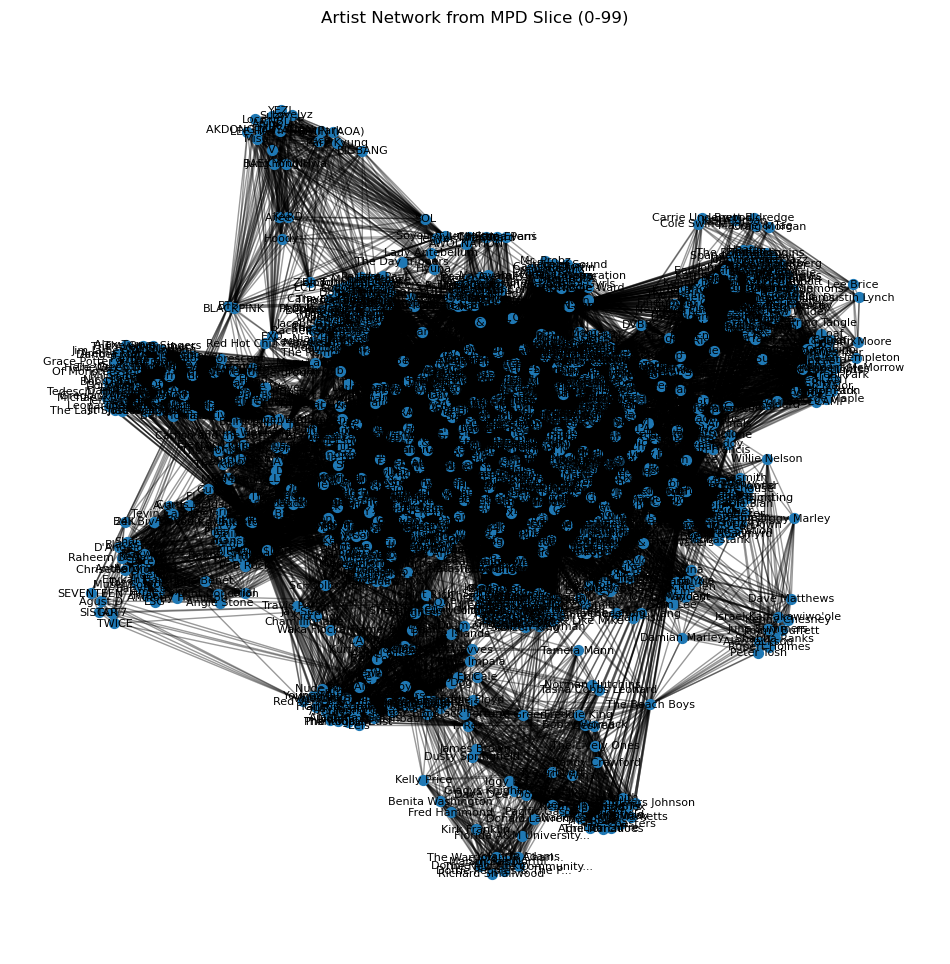

In [9]:
# plot graph
import matplotlib.pyplot as plt

def safe_label(s, maxlen=25):
    s = s.replace('\\', '\\\\')
    s = s.replace('$', r'\$')   # escape dollar signs so math parser won't choke
    s = s.replace('^', r'\^')
    s = s.replace('{', '')
    s = s.replace('}', '')
    s = s.replace('_', ' ')     # avoid subscripts
    s = s.strip()
    return (s[:maxlen-3] + '...') if len(s) > maxlen else s

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.15, iterations=20)

# draw nodes and edges separately (more control)
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.4)

# build sanitized labels dict and draw
labels = {n: safe_label(n) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Artist Network from MPD Slice (0-99)")
plt.axis('off')
plt.show()

In [50]:
# plotting the largest connected component only
largest_cc = max(nx.connected_components(G), key=len)
print(f"Largest connected component size: {len(largest_cc)} nodes")
print(f"We removed {G.number_of_nodes() - len(largest_cc)} nodes not in the largest connected component.")

G_cc = G.subgraph(largest_cc)

Largest connected component size: 15505 nodes
We removed 48 nodes not in the largest connected component.


In [ ]:


plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_cc, k=0.15, iterations=20)
nx.draw_networkx_nodes(G_cc, pos, node_size=50)
nx.draw_networkx_edges(G_cc, pos, alpha=0.4)
nx.draw_networkx_labels(G_cc, pos, labels={n: safe_label(n) for n in G_cc.nodes()}, font_size=8)
plt.title("Largest Connected Component of Artist Network from MPD Slice (0-99)")
plt.axis('off')
plt.show()

KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

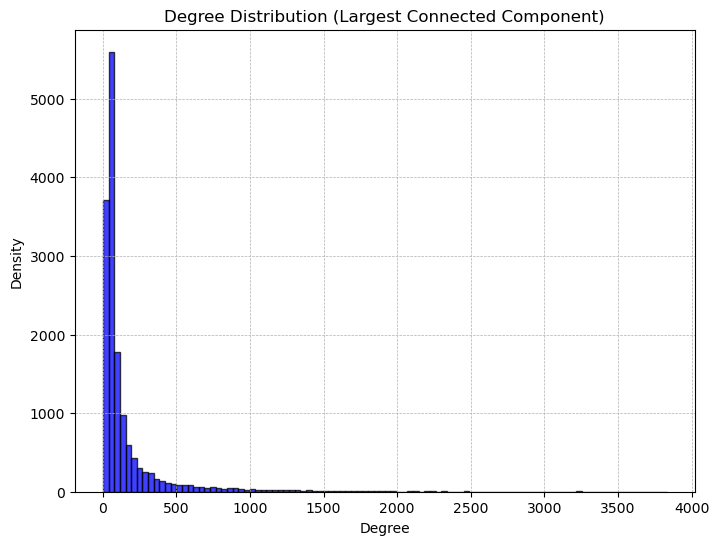

In [51]:
# plot NOT log binned degree distribution
import numpy as np
degrees = [d for n, d in G_cc.degree()]
max_degree = max(degrees)
plt.figure(figsize=(8,6))
plt.hist(degrees, bins = 100, alpha=0.75, color='blue', edgecolor='black') #bins=range(1, max_degree + 2)
plt.xlabel("Degree")
plt.ylabel("Density")
plt.title("Degree Distribution (Largest Connected Component)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


In [52]:
# nodes with most connections
from numpy import number


top_n = 10
top_by_degree = sorted(G_cc.degree, key=lambda x: x[1], reverse=True)[:top_n]
print("\nTop artists by degree (number of connections):")
for artist, degree in top_by_degree:
    print(f" - {artist}: {degree} connections")

# node-pairs with strongest connections
top_by_edge_weight = sorted(G_cc.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:top_n]
print("\nTop artist pairs by edge weight (number of shared playlists):")
for a, b, attr in top_by_edge_weight:
    print(f" - {attr['weight']} : {a} <--> {b}")


bottom_by_degree = sorted(G_cc.degree, key=lambda x: x[1])[:top_n]
print("\nBottom artists by degree (number of connections):")
for artist, degree in bottom_by_degree:
    print(f" - {degree} : {artist}")


Top artists by degree (number of connections):
 - Drake: 3830 connections
 - Rihanna: 3497 connections
 - Coldplay: 3416 connections
 - Kanye West: 3371 connections
 - The Weeknd: 3244 connections
 - Ed Sheeran: 3222 connections
 - Calvin Harris: 3221 connections
 - The Chainsmokers: 3172 connections
 - Kendrick Lamar: 3114 connections
 - Imagine Dragons: 3039 connections

Top artist pairs by edge weight (number of shared playlists):
 - 219 : Drake <--> Kanye West
 - 201 : Drake <--> Kendrick Lamar
 - 178 : Rihanna <--> Drake
 - 175 : Drake <--> Future
 - 174 : Drake <--> Big Sean
 - 174 : Drake <--> The Weeknd
 - 155 : Kendrick Lamar <--> Kanye West
 - 150 : Drake <--> J. Cole
 - 149 : Post Malone <--> Drake
 - 140 : Drake <--> Rae Sremmurd

Bottom artists by degree (number of connections):
 - 2 : David Nevue
 - 2 : Yung Bans
 - 2 : jonatan leandoer127
 - 2 : The Broadway Players
 - 2 : HD Crew
 - 2 : Gorgeous War
 - 2 : Josh Garrells & The Lions
 - 2 : Mr. Shadow
 - 2 : Mr. Knightow

In [57]:
# keep only backbone edges for the Largest CC

def disparity_filter(G, alpha=0.05):
    """
    Implements the Serrano et al. (2009) disparity filter.
    alpha: Significance threshold (cut edges with p-value > alpha)
    """
    B = nx.Graph()
    for u in G.nodes():
        k = len(G[u]) # Degree of node u
        if k > 1:
            sum_w = sum(d['weight'] for v, d in G[u].items())
            for v, d in G[u].items():
                w = d['weight']
                p_ij = w / sum_w # Normalized weight
                
                # Calculate Alpha (p-value equivalent)
                # Formula: (1 - p_ij)^(k-1)
                alpha_ij = (1 - p_ij) ** (k - 1)
                
                # If the link is significant, keep it
                if alpha_ij < alpha:
                    B.add_edge(u, v, weight=w)
    return B

G_backbone = disparity_filter(G_cc, alpha=0.01)

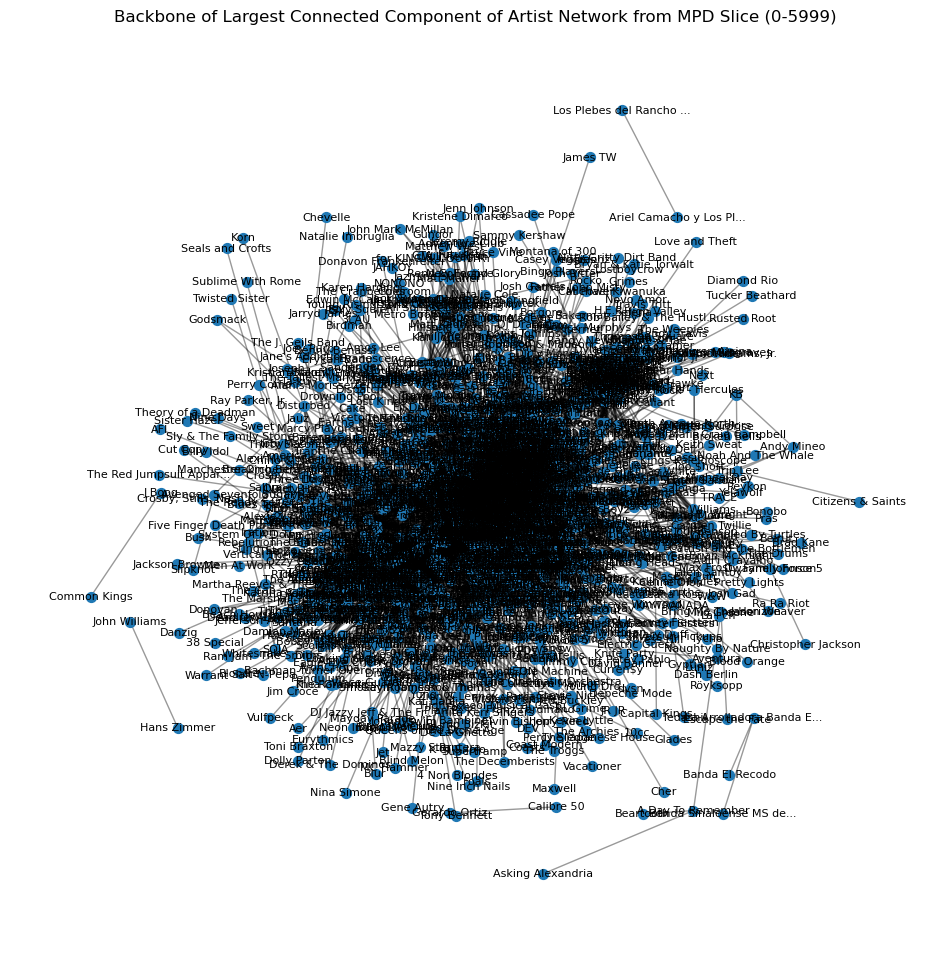

In [58]:
# plot backbone graph
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_backbone, k=0.15, iterations=20)
nx.draw_networkx_nodes(G_backbone, pos, node_size=50)
nx.draw_networkx_edges(G_backbone, pos, alpha=0.4)
nx.draw_networkx_labels(G_backbone, pos, labels={n: safe_label(n) for n in G_backbone.nodes()}, font_size=8)
plt.title("Backbone of Largest Connected Component of Artist Network from MPD Slice (0-5999)")
plt.axis('off')
plt.show()